# Hierarchical LDA

In [842]:
import bz2
from collections import defaultdict
from datetime import datetime, timezone
import json
import logging
import os
import re
import time

import numpy as np
import pandas as pd
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import ldamallet

# nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

pyLDAvis.enable_notebook()
# Enbale logging for gensim
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [643]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.now(timezone.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = False

In [644]:
if DEV:
    RUN_DATE = '2021-03-29'
else:
    RUN_DATE = str(TODAY)
RUN_DATE

'2021-03-29'

### Helper functions

In [840]:
# Pickle a file and then compress it into a file with extension 
def compress_pickle(filepath, data):
    with bz2.BZ2File(filepath + '.pbz2', 'w') as f: 
        pickle.dump(data, f)

In [841]:
# Load any compressed pickle file
def decompress_pickle(filepath):
    data = bz2.BZ2File(filepath, 'rb')
    data = pickle.load(data)
    return data

### Load data

In [646]:
# clean comments
comments_df = pd.read_csv(f'{DATA_DIR}/clean_data_{RUN_DATE}.csv')

In [647]:
comments_df.head()

,comment,title,subreddit,score
0,bold assumption team capable throwing maintaining decent java code agree avoid plugins nasty conflicts plugins libraries updates count spent catering plugin versions devs pushed update center update broke jenkins refuse plugin avoid spending weeks developing internal tool job,building jenkins pipeline,devops,8
1,comparison sense jenkins actively developed maintained,building jenkins pipeline,devops,2
2,supports plugins recreate nightmare,building jenkins pipeline,devops,4
3,reading,building jenkins pipeline,devops,2
4,nailed progression upward forward interested lateral architect position attractive,industries life devops,devops,2


In [648]:
comments_df.shape

(467944, 4)

In [649]:
uniqe_titles = data.title.unique()
print(data.title.unique())

['00 google hold notifications card google subs' '0365 email accounts'
 '0365 roll critical account protection accounts high profile' ...
 'تحميل برنامج إنشاء الصور المتحركة ثلاثية الابعاد blender'
 'تعلم برنامج جوملا اضافة صورة بانر joomla adding banner component'
 'تعلم برنامج جوملا تنزيل لغة اخرى joomla download install lang']


In [651]:
comments_df['comment_len'] = comments_df.comment.apply(len)

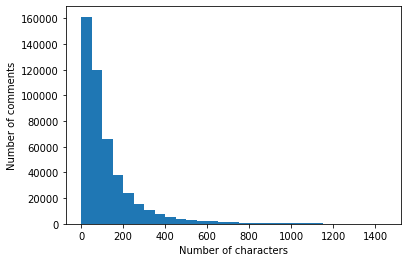

In [653]:
plt.hist(comments_df.comment_len.values, bins = range(0, 1500, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of comments')
plt.show()

## Preprocess comments

1. Combine all comments under the same post - prepend post title
2. Tokenize comments
3. Remove stopwords
5. Make ngrams, stem and lemmatize the tokens (words in comments)
6. Create Bag-of-words and TF-IDF vector representation of the tokens

#### Combining comments under the same title (post)

In [656]:
df_grouped = comments_df.groupby(['title']) #['comment'].transform(lambda x: ' '.join(x))

In [657]:
titles = list(df_grouped.groups.keys())
all_comments = []
for title in titles:
    # combine all comments - prepend title
    title_comments = title + ' ' + ' '.join(
        df_grouped.get_group(title).comment)
    all_comments.append(title_comments)

In [658]:
len(all_comments)

30079

In [659]:
data = pd.DataFrame({
    'title':titles,
    'text': all_comments})

In [843]:
compress_pickle(f'{DATA_DIR}/clean_data_grouped_{RUN_DATE}.pkl', data)

In [848]:
data = decompress_pickle(f'{DATA_DIR}/clean_data_grouped_{RUN_DATE}.pkl.pbz2')

In [847]:
data.shape

(30079, 4)

In [660]:
data.head()

title  \
0  00 google hold notifications card google subs                 
1  0365 email accounts                                           
2  0365 roll critical account protection accounts high profile   
3  06 secret history windows zipfolders original author davepl   
4  10 000 double pendulums double pendulum simulation            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [661]:
data.text[0]

'00 google hold notifications card google subs credit card remember straight update card details domain registrars dumbshitontheright report card lost stolen called citibank safe wait alerts suspicious plenty dispute cancel card 4 charges today odd assume compromised testing card'

### Tokenization


Tokenization is the process of breaking complex data (like paragraphs) into simple units called __tokens__

In [662]:
def tokenize(doc):
    for sentence in doc:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

### Remove stopwords

In [663]:
stop_words = stopwords.words('english')
stop_words.extend(['feel', 'aint', 'wtf', 'hell', 'kid', 'heh', 'ha', 'youtu', 
                   'hmm', 'не', 'kinda', 'fine', 'nah', 'nope', 'huh', 'die',
                   'joke', 'anal' 'yup', 'great', 'fun', 'issue', 'stuff', 'point', 
                   'feel', 'crap', 'fucking', 'fuck', 'dude', 'damn', 'suck',
                   'lmao', 'stupid', 'haha', 'lol', 'nice', 'yeah', 'cool',  
                   'didnt', 'youll', 'youv', 'big', 'yep', 'bot', 'yikes',
                   'ya', 'tho', 'jesus', 'totally', 'chill', 'god', 'amazing',
                   'nep', 'remindme', 'holy', 'as', 'wanna', 'ftw', 'enjoy',
                   'gotta', 'crazy', 'die', 'small', 'hey', 'ban', 'bro',
                   'guess', 'sex', 'kid', 'bad', 'long', 'interesting', 'man',
                   'wrong', 'kid', 'easy', 'difficult', 'upvote', 'like',
                   'funny', 'friend', 'literally', 'hate', 'free', 'sucks',
                   'dont', 'ill', 'https', 'laugh', 'ass', 'omg'])

In [664]:
len(stop_words)

268

In [665]:
def remove_stopwords(doc):
    return doc.apply(
        lambda sent: [word for word in sent if word not in stop_words])

### Stemming
- Stemming is a normalization technique where list of tokenized words are converted into shorter root words called stems (note: stems are not always the root word)
- Drop last letter or prefix or suffix - may not produce meaningful words
- Stemming may reduce the accuracy of the model

In [666]:
def stemming(doc, stemmer_type):
    if stemmer_type=='port':
        stemmer = PorterStemmer()
    elif stemmer_type=='snow':
        stemmer = SnowballStemmer('english')
    stemmed_text = doc.apply(
            lambda sent: [stemmer.stem(word) for word in sent])
    return stemmed_text

### Lemmatization
- Lemmatization is the morphological analysis of the words - returning meaningful words
- Requires more disk space and processing time
- Leads to higher model accuaracy
- Root word is called __lemma__

In [667]:
lemmatizer = WordNetLemmatizer()
def lemmatization(doc):
    return doc.apply(
        lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [668]:
tokenized_text = list(tokenize(data.text))
data['tokens'] = tokenized_text
print('Tokenized:\n', data.tokens[0])

# Remove stopwords
nostops_text = remove_stopwords(data.tokens)
print('\nWithout stopwords:\n', nostops_text[0])
data['tokens'] = nostops_text # replace with clean tokenized

# # Form bigrams and trigrams
# bigram = Phrases(data.tokens, min_count=3, threshold=10) # higher threshold fewer places
# bigram_mod = Phraser(bigram)
# print('\nBigrams:\n', bigram[data.tokens[0]])
# data['bigram'] = [bigram_mod[doc] for doc in data.tokens]

# trigram = Phrases(bigram[data.tokens], threshold=10) # higher threshold fewer places
# trigram_mod = Phraser(trigram)
# print('\nTrigrams:\n', trigram[data.tokens[0]])
# data['trigram'] = [trigram_mod[bigram_mod[doc]] for doc in data.tokens]

# Snowball stemmer
stemmed_text = stemming(data.tokens, 'snow')
data['stem_text'] = stemmed_text 
# data['stem_bi'] = stemming(data.bigram, 'snow')
# data['stem_tri'] = stemming(data.trigram, 'snow')
print('\nStemmed:\n', stemmed_text[0])


# # Lemmatization
# lemmatized_text = lemmatization(data.tokens)
# print('\nLemmatized:\n', lemmatized_text[0])
# data['lemma_text'] = lemmatized_text
# data['lemma_bi'] = lemmatization(data.bigram)
# data['lemma_tri'] = lemmatization(data.trigram)

Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'assume', 'compromised', 'testing', 'card']

Without stopwords:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'report', 'card', 'lost', 'stolen', 'call', 'citibank', 'safe', 'wait', 'alert', 'sus

### Create dictionary, corpus and vectorized corpus needed for topic modeling

In [669]:
data.head()

title  \
0  00 google hold notifications card google subs                 
1  0365 email accounts                                           
2  0365 roll critical account protection accounts high profile   
3  06 secret history windows zipfolders original author davepl   
4  10 000 double pendulums double pendulum simulation            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [852]:
compress_pickle(f'{DATA_DIR}/preprocessed_grouped_data_{RUN_DATE}.pkl', data)

In [853]:
data_test = decompress_pickle(f'{DATA_DIR}/preprocessed_grouped_data_{RUN_DATE}.pkl.pbz2')

In [854]:
data_test.head(3)

,title,text,tokens,stem_text
0,00 google hold notifications card google subs,00 google hold notifications card google subs credit card remember straight update card details domain registrars dumbshitontheright report card lost stolen called citibank safe wait alerts suspicious plenty dispute cancel card 4 charges today odd assume compromised testing card,"[google, hold, notifications, card, google, subs, credit, card, remember, straight, update, card, details, domain, registrars, report, card, lost, stolen, called, citibank, safe, wait, alerts, suspicious, plenty, dispute, cancel, card, charges, today, odd, assume, compromised, testing, card]","[googl, hold, notif, card, googl, sub, credit, card, rememb, straight, updat, card, detail, domain, registrar, report, card, lost, stolen, call, citibank, safe, wait, alert, suspici, plenti, disput, cancel, card, charg, today, odd, assum, compromis, test, card]"
1,0365 email accounts,0365 email accounts mfa defender office 365 plan add users phished credential stuffed comprises block powershell access admin account attackers configuring auto forward rules prem exchange hafnium disable legacy enable mfa force password reset implement password history restriction legacy compromise vectors exchange online june hafnium edit,"[email, accounts, mfa, defender, office, plan, add, users, phished, credential, stuffed, comprises, block, powershell, access, admin, account, attackers, configuring, auto, forward, rules, prem, exchange, hafnium, disable, legacy, enable, mfa, force, password, reset, implement, password, history, restriction, legacy, compromise, vectors, exchange, online, june, hafnium, edit]","[email, account, mfa, defend, offic, plan, add, user, phish, credenti, stuf, compris, block, powershel, access, admin, account, attack, configur, auto, forward, rule, prem, exchang, hafnium, disabl, legaci, enabl, mfa, forc, password, reset, implement, password, histori, restrict, legaci, compromis, vector, exchang, onlin, june, hafnium, edit]"
2,0365 roll critical account protection accounts high profile,0365 roll critical account protection accounts high profile pay play protection offers read tag users executive reports separate users users graphs organisations love frankly idea pay,"[roll, critical, account, protection, accounts, high, profile, pay, play, protection, offers, read, tag, users, executive, reports, separate, users, users, graphs, organisations, love, frankly, idea, pay]","[roll, critic, account, protect, account, high, profil, pay, play, protect, offer, read, tag, user, execut, report, separ, user, user, graph, organis, love, frank, idea, pay]"


In [790]:
# Create dictionary representation of the documents
def build_corpus(doc, filter_extremes=True):
    doc_dict = corpora.Dictionary(doc)
    if filter_extremes:
        # Filter out words that occur in less than 20% documents, and above 50% documents
        doc_dict.filter_extremes(no_below=20, no_above=0.5)
    # Bag of words
    corpus = [doc_dict.doc2bow(text) for text in doc]
    # Compute TF-IDF score for each word in BoW (stemmed corpus)
    tfidf_mod = TfidfModel(corpus, normalize=True)
    vec_corpus = tfidf_mod[corpus]
    return doc_dict, corpus, vec_corpus, tfidf_mod

In [791]:
# Build stem corpus
dict_stem, corpus_stem, vec_corpus_stem, tfid_stem_mod = build_corpus(data.stem_text)
# dict_stem_bi, corpus_stem_bi, vec_corpus_stem_bi, tfid_stem_bi_mod = build_corpus(data.stem_bi)
# dict_stem_tri, corpus_stem_tri, vec_corpus_stem_tri, tfid_stem_tri_mod = build_corpus(data.stem_tri)


In [792]:
dict_stem[1]

'assum'

In [673]:
# corpus_stem

### Building the topic model

In [674]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [675]:
# Print the keywords in the topics
def print_topics(model):
    for topic_num, words_in_topic in model.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [676]:
def print_coherence_score(model, corpus, dictionary, texts):
    # Compute Perplexity - lemmatized
    print(f'\n- Perplexity: {model.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

In [677]:
# corpus - bow/tfidf dictionary of lemmatized or stemmed words

def build_lda(
    corpus, dictionary, corpus_type, num_topics, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building LDA model using {corpus_type} corpus...')
    mod = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       chunksize=chunksize,
                       passes=passes,
                       iterations=iterations,
                       workers=workers,
                       eval_every=eval_every)
    print(f' - {time.time()-start:.4f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

## 2 top level topics

In [678]:
pd.set_option('display.max_colwidth', False)

In [689]:
# # Human readable form of the BoW
print([[(dict_stem[id], freq) for id, freq in word] for word in corpus[:2]])

[[('alert', 1), ('assum', 1), ('call', 1), ('cancel', 1), ('card', 1), ('charg', 1), ('compromis', 1), ('credit', 1), ('detail', 1), ('disput', 1), ('domain', 1), ('googl', 1), ('hold', 1), ('lost', 1), ('notif', 1), ('odd', 1), ('plenti', 1), ('registrar', 1), ('rememb', 1), ('report', 1)]]


In [690]:
# nope
# sub_lda_mod = build_lda(
#     corpus=vec_corpus,
#     dictionary=topic_dict,
#     corpus_type='tfidf-stem-sub',
#     texts=topic_terms_series,
#     num_topics=2)

In [691]:
# # nope - error
# sub_lda_mod = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=topic_dict,
#     corpus_type='tfidf-stem-sub',
#     texts=topic_terms_series,
#     num_topics=2)

In [692]:
# # nope
# sub_lda_mod = build_lda(
#     corpus=vec_corpus,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem-sub',
#     texts=topic_terms_series,
#     num_topics=2)

In [ ]:
# # nope
# sub_lda_mod = build_lda(
#     corpus=vec_corpus,
#     dictionary=topic_dict,
#     corpus_type='tfidf-stem-sub',
#     texts=data.stem_text,
#     num_topics=2)

In [694]:
# # nope - error
# sub_lda_mod = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=topic_dict,
#     corpus_type='tfidf-stem-sub',
#     texts=data.stem_text,
#     num_topics=2)

In [695]:
# # nope
# sub_lda_mod = build_lda(
#     corpus=vec_corpus,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem-sub',
#     texts=data.stem_text,
#     num_topics=2)

In [696]:
# # MAYBE!
# sub_lda_mod1 = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem-sub',
#     texts=topic_terms_series,
#     num_topics=2)

In [697]:
# viz = pyLDAvis.gensim.prepare(sub_lda_mod1, vec_corpus_stem, dict_stem)
# viz

In [698]:
# # MAYBE!
# sub_lda_mod2 = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem-sub',
#     texts=data.stem_text,
#     num_topics=2)

In [700]:
# viz = pyLDAvis.gensim.prepare(sub_lda_mod2, vec_corpus_stem, dict_stem)
# viz

In [701]:
# partition into list of lists and return pd.Series
# n - number of words per chunk
def chunk_it(list, n):
    list_chunks = [
            list[i:i+n] for i in range(0, len(list), n)]
    return pd.Series(list_chunks)

In [707]:
# Iterate over given topic
# Extract topic terms and build corpus
# Build lda with top-specific corpus

sub_lda_corpus_n_mod_dict = {}
def build_multi_lda(
    mod, top_topics=2, sub_topics=2, words_to_extract=10000, words_per_chunk=100):
    for topic_id in range(top_topics):
        print('\n**\nTop-level topic-id:', topic_id)
        topic_terms = [word for word, prob in mod.show_topic(topic_id, words_to_extract)]
        topic_terms_series = chunk_it(topic_terms, words_per_chunk)          
        print(topic_terms_series[:3])
        (topic_dict, corpus, 
         vec_corpus, tfid_mod) = build_corpus(topic_terms_series, False)
        sub_lda_mod = build_lda(
            corpus=vec_corpus,
            dictionary=topic_dict,
            corpus_type='tfidf-stem-sub',
            texts=topic_terms_series,
            num_topics=sub_topics)
        sub_lda_corpus_n_mod_dict[topic_id] = {
            'mod': sub_lda_mod,
            'topic_dict': topic_dict,
            'corpus': corpus,
            'vec_corpus': vec_corpus,
            'text': topic_terms_series}
    return sub_lda_corpus_n_mod_dict

In [708]:
# 2 topic tfidf-stem corpus
lda_tfidf_stem_2top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=2)

Building LDA model using tfidf-stem corpus...
 - 284.4913s

Topic 1:  Words: 0.004*"learn" + 0.003*"code" + 0.003*"secur" + 0.003*"job" + 0.003*"compani" + 0.003*"program" + 0.003*"data" + 0.002*"project" + 0.002*"model" + 0.002*"develop"
Topic 2:  Words: 0.006*"server" + 0.005*"window" + 0.004*"user" + 0.003*"file" + 0.003*"devic" + 0.003*"connect" + 0.003*"network" + 0.003*"switch" + 0.003*"instal" + 0.003*"updat"

- Perplexity: -8.5462
- Coherence Score: 0.4732


In [709]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_2top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.117001  0.0  1       1        54.252529
1     -0.117001  0.0  2       1        45.747475, topic_info=          Term        Freq       Total Category  logprob  loglift
819   server    479.000000  479.000000  Default  30.0000  30.0000
115   window    391.000000  391.000000  Default  29.0000  29.0000
399   learn     361.000000  361.000000  Default  28.0000  28.0000
251   devic     279.000000  279.000000  Default  27.0000  27.0000
200   code      353.000000  353.000000  Default  26.0000  26.0000
...    ...             ...         ...      ...      ...      ...
1088  address   174.996475  199.549255  Topic2  -6.1872   0.6507 
591   support   197.495316  273.275055  Topic2  -6.0663   0.4573 
55    password  198.074387  316.373932  Topic2  -6.0633   0.3138 
30    account   181.627106  256.793518  Topic2  -6.1500   0.4357 
1493  servic    179.521790  266.842377  Topic2  -6.1617   0.3857 

[155 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
29    1      0.165910  access  
29    2      0.833322  access  
30    1      0.292063  account 
30    2      0.708741  account 
1088  1      0.125282  address 
...  ..           ...      ... 
1060  2      0.987186  wireless
799   1      0.550190  work    
799   2      0.449861  work    
655   1      0.860739  write   
655   2      0.138143  write   

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [710]:
sub_lda_2top_mod_dict = build_multi_lda(
    lda_tfidf_stem_2top_mod,
    2, # top_topics
    2, # sub_topics
    5000, # num_words_to_extract
    50) # num_words_per_chunk


**
Top-level topic-id: 0
0    [learn, code, secur, job, compani, program, data, project, model, develop, languag, team, train, start, post, experi, engin, paper, tool, manag, read, python, question, test, person, work, cyber, github, email, understand, problem, write, cybersecur, video, devop, day, cert, network, imag, attack, articl, build, googl, sourc, softwar, hack, level, function, idea, pay]                     
1    [link, skill, interview, field, ai, busi, type, role, open, posit, product, certif, password, comment, book, implement, api, comput, basic, web, answer, app, aw, sysadmin, degre, applic, knowledg, text, process, base, org, document, week, websit, number, hire, reddit, practic, kind, autom, tech, talk, real, money, hour, help, dev, technic, creat, requir]                                   
2    [librari, class, generat, cloud, featur, list, chang, depend, resourc, general, task, dataset, case, recommend, search, month, check, bit, high, system, algorithm, review, sta

In [711]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_corpus_n_mod_dict[0]['mod'], 
#     sub_lda_corpus_n_mod_dict[0]['vec_corpus'], 
#     sub_lda_corpus_n_mod_dict[0]['topic_dict'])
# viz

___

### 3 top level, 2 sub-level topics

In [713]:
# 3 topic tfidf-stem corpus
lda_tfidf_stem_3top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=3)

Building LDA model using tfidf-stem corpus...
 - 274.8047s

Topic 1:  Words: 0.007*"server" + 0.005*"window" + 0.005*"user" + 0.005*"password" + 0.004*"file" + 0.004*"network" + 0.004*"connect" + 0.004*"devic" + 0.004*"email" + 0.004*"instal"
Topic 2:  Words: 0.005*"game" + 0.005*"card" + 0.004*"intel" + 0.004*"price" + 0.004*"power" + 0.004*"amd" + 0.004*"gpu" + 0.004*"cpu" + 0.004*"laptop" + 0.003*"nvidia"
Topic 3:  Words: 0.004*"learn" + 0.004*"code" + 0.003*"job" + 0.003*"secur" + 0.003*"compani" + 0.003*"program" + 0.003*"project" + 0.003*"data" + 0.002*"languag" + 0.002*"model"

- Perplexity: -8.6404
- Coherence Score: 0.5546


In [715]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_3top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.011377 -0.123535  1       1        46.191021
0     -0.149709  0.054448  2       1        33.962723
1      0.138332  0.069086  3       1        19.846260, topic_info=          Term        Freq       Total Category  logprob  loglift
819   server    468.000000  468.000000  Default  30.0000  30.0000
55    password  305.000000  305.000000  Default  29.0000  29.0000
4     card      190.000000  190.000000  Default  28.0000  28.0000
333   game      222.000000  222.000000  Default  27.0000  27.0000
3105  intel     165.000000  165.000000  Default  26.0000  26.0000
...     ...            ...         ...      ...      ...      ...
1640  drive     91.450249   193.970276  Topic3  -6.0011   0.8652 
771   market    74.555870   127.632278  Topic3  -6.2053   1.0796 
2752  seri      69.451775   104.026207  Topic3  -6.2762   1.2131 
1781  dell      66.404381   92.927437   Topic3  -6.3211   1.2811 
979   product   70.306068   237.028137  Topic3  -6.2640   0.4018 

[216 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
29    1      0.142816  access 
29    2      0.822159  access 
29    3      0.038599  access 
30    1      0.147996  account
30    2      0.827975  account
...  ..           ...      ...
655   2      0.128222  write  
655   3      0.074796  write  
4363  2      0.982602  wsus   
801   3      0.973014  xt     
3261  3      0.985125  zen    

[363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [727]:
sub_lda_3top_mod_dict = build_multi_lda(
    lda_tfidf_stem_3top_mod,
    3, # top_topics
    2, # sub_topics
    5000, # num_words_to_extract
    50) # num_words_per_chunks


**
Top-level topic-id: 0
0    [server, window, user, password, file, network, connect, devic, email, instal, switch, vpn, updat, domain, access, account, microsoft, port, set, log, router, servic, client, dns, firewal, address, secur, manag, host, backup, licens, vlan, app, traffic, rout, site, configur, remot, check, polici, azur, support, admin, machin, local, exchang, group, cisco, work, vm]          
1    [internet, offic, encrypt, run, chang, setup, phone, key, folder, solut, cloud, authent, isp, powershel, issu, option, softwar, share, script, comput, control, download, interfac, block, gpo, send, data, creat, googl, deploy, link, patch, login, provid, command, dhcp, enabl, default, wifi, version, mail, disabl, drive, activ, printer, mac, packet, problem, subnet, question] 
2    [migrat, tool, permiss, browser, monitor, open, add, delet, outlook, config, attack, linux, desktop, certif, error, protect, remov, requir, reboot, virtual, credenti, rule, test, scan, sync, rdp, upgrad,

In [728]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_3top_mod_dict[0]['mod'], 
    sub_lda_3top_mod_dict[0]['vec_corpus'],
    sub_lda_3top_mod_dict[0]['topic_dict'])
viz

PreparedData(topic_coordinates=              x    y  topics  cluster     Freq
topic                                         
1      0.003486  0.0  1       1        50.8228
0     -0.003486  0.0  2       1        49.1772, topic_info=          Term      Freq    Total Category  logprob  loglift
3345  timelin   0.000000  0.00000  Default  30.0000  30.0000
409   captur    0.000000  0.00000  Default  29.0000  29.0000
446   ubiqu     0.000000  0.00000  Default  28.0000  28.0000
1388  social    0.000000  0.00000  Default  27.0000  27.0000
1381  pictur    0.000000  0.00000  Default  26.0000  26.0000
...      ...         ...      ...      ...      ...      ...
3346  tlds      0.077972  0.14118  Topic2  -8.4028   0.1161 
3300  accommod  0.077972  0.14118  Topic2  -8.4028   0.1161 
1382  prior     0.077972  0.14118  Topic2  -8.4028   0.1161 
3317  exempt    0.077972  0.14118  Topic2  -8.4028   0.1161 
3302  ao        0.077972  0.14118  Topic2  -8.4028   0.1161 

[91 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [729]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_3top_mod_dict[1]['mod'], 
    sub_lda_3top_mod_dict[1]['vec_corpus'],
    sub_lda_3top_mod_dict[1]['topic_dict'])
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.003493  0.0  1       1        50.822418
1     -0.003493  0.0  2       1        49.177574, topic_info=           Term      Freq     Total Category  logprob  loglift
3215  hog        0.000000  0.000000  Default  30.0000  30.000 
3246  unsur      0.000000  0.000000  Default  29.0000  29.000 
3235  showcas    0.000000  0.000000  Default  28.0000  28.000 
1413  element    0.000000  0.000000  Default  27.0000  27.000 
3216  inconsist  0.000000  0.000000  Default  26.0000  26.000 
...         ...       ...       ...      ...      ...     ... 
1422  hype       0.077971  0.141179  Topic2  -8.4029   0.116  
3217  jail       0.077971  0.141179  Topic2  -8.4029   0.116  
3201  bake       0.077971  0.141179  Topic2  -8.4029   0.116  
1409  compact    0.077971  0.141179  Topic2  -8.4029   0.116  
3238  strateg    0.077971  0.141179  Topic2  -8.4029   0.116  

[91 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [730]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_3top_mod_dict[2]['mod'], 
    sub_lda_3top_mod_dict[2]['vec_corpus'],
    sub_lda_3top_mod_dict[2]['topic_dict'])
viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003488  0.0  1       1        51.644676
0     -0.003488  0.0  2       1        48.355328, topic_info=         Term      Freq     Total Category  logprob  loglift
1596  verifi   0.000000  0.000000  Default  30.0000  30.0000
1591  sub      0.000000  0.000000  Default  29.0000  29.0000
1566  freedom  0.000000  0.000000  Default  28.0000  28.0000
1554  conduct  0.000000  0.000000  Default  27.0000  27.0000
1551  caught   0.000000  0.000000  Default  26.0000  26.0000
...      ...        ...       ...      ...      ...      ...
4475  magazin  0.076847  0.140929  Topic2  -8.4005   0.1202 
1437  polic    0.076847  0.140929  Topic2  -8.4005   0.1202 
1577  memor    0.076847  0.140929  Topic2  -8.4005   0.1202 
269   hacker   0.076847  0.140929  Topic2  -8.4005   0.1202 
2287  spread   0.076847  0.140929  Topic2  -8.4005   0.1202 

[90 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

___

### 4 top level, 3 sub level topics

In [718]:
# 4 topic tfidf-stem corpus
lda_tfidf_stem_4top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=4)

Building LDA model using tfidf-stem corpus...
 - 284.0251s

Topic 1:  Words: 0.009*"network" + 0.009*"router" + 0.008*"port" + 0.008*"switch" + 0.008*"vpn" + 0.007*"dns" + 0.007*"connect" + 0.007*"vlan" + 0.007*"firewal" + 0.007*"traffic"
Topic 2:  Words: 0.008*"window" + 0.007*"server" + 0.007*"password" + 0.007*"user" + 0.007*"file" + 0.005*"instal" + 0.005*"updat" + 0.005*"microsoft" + 0.004*"email" + 0.004*"account"
Topic 3:  Words: 0.005*"model" + 0.004*"intel" + 0.004*"card" + 0.004*"game" + 0.004*"amd" + 0.004*"gpu" + 0.004*"perform" + 0.004*"power" + 0.003*"price" + 0.003*"nvidia"
Topic 4:  Words: 0.004*"secur" + 0.003*"code" + 0.003*"learn" + 0.003*"job" + 0.003*"compani" + 0.003*"program" + 0.002*"project" + 0.002*"languag" + 0.002*"develop" + 0.002*"team"

- Perplexity: -8.7335
- Coherence Score: 0.6076


In [719]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_4top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.055100 -0.061431  1       1        46.383354
1     -0.106328 -0.103234  2       1        21.307148
2      0.162749  0.039275  3       1        19.386415
0     -0.111521  0.125391  4       1        12.923079, topic_info=          Term        Freq       Total Category  logprob  loglift
2671  router    212.000000  212.000000  Default  30.0000  30.0000
1587  network   428.000000  428.000000  Default  29.0000  29.0000
1463  vpn       237.000000  237.000000  Default  28.0000  28.0000
487   port      240.000000  240.000000  Default  27.0000  27.0000
819   server    482.000000  482.000000  Default  26.0000  26.0000
...      ...           ...         ...      ...      ...      ...
819   server    126.296928  482.367035  Topic4  -5.2492   0.7061 
37    configur  78.481705   183.503418  Topic4  -5.7250   1.1968 
1151  client    80.377983   220.046844  Topic4  -5.7011   1.0391 
786   site      78.710945   217.409302  Topic4  -5.7221   1.0302 
29    access    71.110939   266.407135  Topic4  -5.8236   0.7254 

[289 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4961  2      0.955819  aad   
29    1      0.236480  access
29    2      0.465453  access
29    3      0.030029  access
29    4      0.266509  access
...  ..           ...     ...
655   3      0.086727  write 
655   4      0.010841  write 
4363  2      0.986925  wsus  
801   3      0.969241  xt    
3261  3      0.990435  zen   

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [720]:
sub_lda_4top_3sub_mod_dict = build_multi_lda(
    lda_tfidf_stem_4top_mod, 
    4, # top_topics
    3, # sub_topics
    5000, # num_words_to_extract
    50) # num_words_per_chunk


**
Top-level topic-id: 0
0    [network, router, port, switch, vpn, dns, connect, vlan, firewal, traffic, rout, devic, cisco, server, address, isp, dhcp, wifi, subnet, packet, interfac, internet, client, site, configur, tunnel, access, wireless, ping, gateway, wan, proxi, host, ipv, set, ip, tcp, nat, domain, servic, mac, provid, lan, config, static, ethernet, block, protocol, bgp, setup]          
1    [layer, support, nic, fiber, rule, public, cabl, wireshark, phone, modem, ssl, ap, link, certif, default, check, aruba, control, issu, bandwidth, fortig, tls, forward, meraki, speed, intern, remot, secur, work, local, request, question, problem, option, user, manag, pfsens, asa, trunk, udp, send, junip, ubiqu, vendor, chang, bridg, solut, broadcast, ssh, sonicwal]    
2    [destin, arp, run, cert, snmp, zone, mtu, direct, poe, acl, window, log, privat, locat, assign, peer, homenetwork, authent, enabl, disabl, openvpn, filter, wire, monitor, fortinet, unifi, separ, resolv, record, test, 

In [723]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_4top_3sub_mod_dict[0]['mod'], 
    sub_lda_4top_3sub_mod_dict[0]['vec_corpus'],
    sub_lda_4top_3sub_mod_dict[0]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.005574 -0.002928  1       1        34.777565
1     -0.005573 -0.002931  2       1        34.777527
2     -0.000002  0.005859  3       1        30.444908, topic_info=           Term      Freq     Total Category  logprob  loglift
4631  mt         0.000000  0.000000  Default  30.0000  30.0000
3727  pack       0.000000  0.000000  Default  29.0000  29.0000
4991  thrill     0.000000  0.000000  Default  28.0000  28.0000
1548  unencrypt  0.000000  0.000000  Default  27.0000  27.0000
1882  onboard    0.000000  0.000000  Default  26.0000  26.0000
...       ...         ...       ...      ...      ...      ...
3738  scrambl    0.054284  0.140058  Topic3  -8.2855   0.2414 
4853  brazil     0.054284  0.140058  Topic3  -8.2855   0.2414 
4964  fort       0.054284  0.140058  Topic3  -8.2855   0.2414 
756   coax       0.054284  0.140058  Topic3  -8.2855   0.2414 
766   face       0.054284  0.140058  Topic3  -8.2855   0.2414 

[132 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [724]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_4top_3sub_mod_dict[1]['mod'], 
    sub_lda_4top_3sub_mod_dict[1]['vec_corpus'],
    sub_lda_4top_3sub_mod_dict[1]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.006428 -0.001111  1       1        38.242958
2      0.004329 -0.004248  2       1        32.178490
0      0.002099  0.005359  3       1        29.578552, topic_info=            Term      Freq     Total Category  logprob  loglift
770   fslogix     0.000000  0.000000  Default  30.0000  30.0000
4085  proven      0.000000  0.000000  Default  29.0000  29.0000
4507  delin       0.000000  0.000000  Default  28.0000  28.0000
2380  manner      0.000000  0.000000  Default  27.0000  27.0000
3393  suck        0.000000  0.000000  Default  26.0000  26.0000
...    ...             ...       ...      ...      ...      ...
4837  shortcom    0.052936  0.139539  Topic3  -8.2817   0.2489 
4537  relentless  0.052936  0.139539  Topic3  -8.2817   0.2489 
4413  freeli      0.052936  0.139539  Topic3  -8.2817   0.2489 
1121  ingest      0.052936  0.139539  Topic3  -8.2817   0.2489 
1924  present     0.052936  0.139539  Topic3  -8.2817   0.2489 

[125 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [725]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_4top_3sub_mod_dict[2]['mod'], 
    sub_lda_4top_3sub_mod_dict[2]['vec_corpus'],
    sub_lda_4top_3sub_mod_dict[2]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.006219  0.000001  1       1        33.911022
2     -0.003108 -0.005296  2       1        33.044525
0     -0.003111  0.005295  3       1        33.044445, topic_info=             Term      Freq    Total Category  logprob  loglift
3771  ordinari     0.000000  0.00000  Default  30.0000  30.0000
3317  gamersnexus  0.000000  0.00000  Default  29.0000  29.0000
4566  forgiv       0.000000  0.00000  Default  28.0000  28.0000
720   lstm         0.000000  0.00000  Default  27.0000  27.0000
3079  khz          0.000000  0.00000  Default  26.0000  26.0000
...   ...               ...      ...      ...      ...      ...
1468  feedback     0.058267  0.14129  Topic3  -8.2966   0.2215 
4400  analyt       0.058267  0.14129  Topic3  -8.2966   0.2215 
2708  disrupt      0.058267  0.14129  Topic3  -8.2966   0.2215 
687   provid       0.058267  0.14129  Topic3  -8.2966   0.2215 
4190  subfield     0.058267  0.14129  Topic3  -8.2966   0.2215 

[128 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [726]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_4top_3sub_mod_dict[3]['mod'], 
    sub_lda_4top_3sub_mod_dict[3]['vec_corpus'],
    sub_lda_4top_3sub_mod_dict[3]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006346 -0.001693  1       1        39.109333
2     -0.004967 -0.003646  2       1        33.045452
1     -0.001379  0.005339  3       1        27.845213, topic_info=          Term      Freq     Total Category  logprob  loglift
2867  genet     0.000000  0.000000  Default  30.0000  30.000 
2098  unsaf     0.000000  0.000000  Default  29.0000  29.000 
2376  ocean     0.000000  0.000000  Default  28.0000  28.000 
4356  breez     0.000000  0.000000  Default  27.0000  27.000 
741   size      0.000000  0.000000  Default  26.0000  26.000 
...    ...           ...       ...      ...      ...     ... 
1425  incompet  0.050211  0.138624  Topic3  -8.2742   0.263  
249   written   0.050211  0.138624  Topic3  -8.2742   0.263  
728   match     0.050211  0.138624  Topic3  -8.2742   0.263  
3583  pypi      0.050211  0.138624  Topic3  -8.2742   0.263  
2398  wish      0.050210  0.138624  Topic3  -8.2742   0.263  

[123 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

___

### 4 top level, 4 sub level topics

In [314]:
# # 4 topic tfidf-stem corpus
# lda_tfidf_stem_4top_mod = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem',
#     texts=data.stem_text,
#     num_topics=4)

In [ ]:
# viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_4top_mod, vec_corpus_stem, dict_stem)
# viz

In [ ]:
# sub_lda_4top_4sub_mod_dict = build_multi_lda(
#     lda_tfidf_stem_4top_mod, 
#     4, # top_topics
#     4, # sub_topics
#     5000, # num_words_to_extract
#     50) # num_words_per_chunk

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_mod_dict[0]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_mod_dict[1]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_mod_dict[2]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_mod_dict[3]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

___

### 4 top level, 4 sub level topics, 10000 words, 100 words chunks

In [321]:
# # 4 topic tfidf-stem corpus
# lda_tfidf_stem_4top_mod = build_lda(
#     corpus=vec_corpus_stem,
#     dictionary=dict_stem,
#     corpus_type='tfidf-stem',
#     texts=data.stem_text,
#     num_topics=4)

In [322]:
# viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_4top_mod, vec_corpus_stem, dict_stem)
# viz

In [ ]:
# sub_lda_4top_4sub_plus_mod_dict = build_multi_lda(
#     lda_tfidf_stem_4top_mod, 
#     4, # top_topics
#     4, # sub_topics
#     10000, # num_words
#     100) # num_chunks

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_plus_mod_dict[0]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_plus_mod_dict[0]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_plus_mod_dict[1]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_plus_mod_dict[2]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_4top_4sub_plus_mod_dict[3]['mod'], 
#     vec_corpus_stem,
#     dict_stem)
# viz

___

### 7 top level

In [731]:
# 7 topic tfidf-stem corpus
lda_tfidf_stem_7top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus...
 - 279.9100s

Topic 1:  Words: 0.006*"code" + 0.005*"languag" + 0.005*"model" + 0.004*"learn" + 0.004*"paper" + 0.004*"python" + 0.004*"data" + 0.003*"program" + 0.003*"github" + 0.003*"imag"
Topic 2:  Words: 0.009*"password" + 0.009*"server" + 0.008*"user" + 0.008*"domain" + 0.007*"vpn" + 0.007*"dns" + 0.007*"connect" + 0.006*"window" + 0.006*"log" + 0.006*"vlan"
Topic 3:  Words: 0.014*"file" + 0.012*"window" + 0.010*"server" + 0.009*"backup" + 0.009*"instal" + 0.009*"updat" + 0.007*"drive" + 0.007*"folder" + 0.006*"disk" + 0.006*"vm"
Topic 4:  Words: 0.019*"cabl" + 0.018*"fiber" + 0.014*"sfp" + 0.011*"poe" + 0.011*"optic" + 0.010*"switch" + 0.009*"port" + 0.009*"ethernet" + 0.007*"cat" + 0.006*"transceiv"
Topic 5:  Words: 0.009*"wvd" + 0.008*"kms" + 0.006*"qt" + 0.004*"zig" + 0.004*"wasm" + 0.004*"protonmail" + 0.004*"clipboard" + 0.003*"racket" + 0.003*"deno" + 0.003*"metaprogram"
Topic 6:  Words: 0.004*"secur" + 0.003*"compani" + 0.003*

In [732]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_mod, vec_corpus_stem, dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.027858 -0.034356  1       1        42.812107
0      0.036446 -0.112335  2       1        20.934256
6     -0.040604 -0.156938  3       1        12.483193
1      0.201040  0.083714  4       1        12.200215
2      0.159028  0.069658  5       1        7.178822 
3     -0.202543  0.093740  6       1        2.341554 
4     -0.181225  0.056516  7       1        2.049863 , topic_info=        Term        Freq       Total Category  logprob  loglift
894   file    339.000000  339.000000  Default  30.0000  30.0000
819   server  480.000000  480.000000  Default  29.0000  29.0000
1565  cabl    165.000000  165.000000  Default  28.0000  28.0000
1028  switch  286.000000  286.000000  Default  27.0000  27.0000
115   window  396.000000  396.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
3580  turbo   10.134073   18.087446   Topic7  -5.9307   3.3081 
9742  ebook   7.840827    11.877053   Topic7  -6.1873   3.4721 
8068  hn      7.805923    11.974010   Topic7  -6.1917   3.4595 
1530  elixir  7.287658    11.317478   Topic7  -6.2604   3.4472 
803   ctrl    8.067622    22.667776   Topic7  -6.1587   2.8543 

[486 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4961  1      0.036503  aad   
4961  4      0.949075  aad   
29    1      0.406445  access
29    2      0.069019  access
29    3      0.026841  access
...  ..           ...     ...
801   3      0.977425  xt    
7579  2      0.919229  yaml  
3261  1      0.021338  zen   
3261  3      0.960194  zen   
5711  7      0.965973  zig   

[1182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 2, 3, 4, 5])

In [734]:
topic_terms_n_data = defaultdict(dict)
def get_topic_terms_n_data(df, mod, num_topics, num_terms):      
    for topic_id in range(num_topics):
        # get topic terms
        topic_terms = [
            word for word, prob in mod.show_topic(topic_id, num_terms)]
        topic_terms_n_data[topic_id]['terms'] = topic_terms
        # get topic comments using topic_terms
        mask = df.comment.apply(lambda x: any(term for term in topic_terms if term in x))
        topic_df = df[mask]
        # combine all topic comments under the same title - prepend title
        topic_df_grouped = topic_df.groupby(['title'])
        topic_titles = list(topic_df_grouped.groups.keys())
        topic_comments = []
        for title in topic_titles:
            title_comments = title + ' ' + ' '.join(
                    topic_df_grouped.get_group(title).comment)
            topic_comments.append(title_comments)         
        topic_data = pd.DataFrame({
            'title': topic_titles,
            'text': topic_comments})
        # preprocess comments
        topic_data = preprocess(topic_data)
        topic_terms_n_data[topic_id]['data'] = topic_data
    return topic_terms_n_data

In [735]:
topic_terms_n_data = get_topic_terms_n_data(comments_df, lda_tfidf_stem_7top_mod, 7, 20)



Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'assume', 'compromised', 'testing', 'card']

Without stopwords:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'call', 'citibank', 'safe', 'wait', 'alert', 'suspici', 'plenti', 'disput', 'cancel', 'card', 'charg', 'today', 'odd', 'assum', 'compromis', 'test', 'card'

In [787]:
topic_terms_n_data[0]['data'][:2]

,title,text,tokens,stem_text
0,00 google hold notifications card google subs,00 google hold notifications card google subs credit card remember straight update card details domain registrars called citibank safe wait alerts suspicious plenty dispute cancel card 4 charges today odd assume compromised testing card,"[google, hold, notifications, card, google, subs, credit, card, remember, straight, update, card, details, domain, registrars, called, citibank, safe, wait, alerts, suspicious, plenty, dispute, cancel, card, charges, today, odd, assume, compromised, testing, card]","[googl, hold, notif, card, googl, sub, credit, card, rememb, straight, updat, card, detail, domain, registrar, call, citibank, safe, wait, alert, suspici, plenti, disput, cancel, card, charg, today, odd, assum, compromis, test, card]"
1,06 secret history windows zipfolders original author davepl,06 secret history windows zipfolders original author davepl high quality video fairly,"[secret, history, windows, zipfolders, original, author, davepl, high, quality, video, fairly]","[secret, histori, window, zipfold, origin, author, davepl, high, qualiti, video, fair]"


In [788]:
topic_terms_n_data[0]['data'].shape

(22862, 4)

In [736]:
topic_terms_n_data[0]['terms']

['code',
 'languag',
 'model',
 'learn',
 'paper',
 'python',
 'data',
 'program',
 'github',
 'imag',
 'project',
 'train',
 'develop',
 'function',
 'write',
 'tool',
 'dataset',
 'test',
 'docker',
 'ai']

In [746]:
topic_terms_n_data[1]['terms']

['intel',
 'amd',
 'card',
 'game',
 'nvidia',
 'gpu',
 'price',
 'power',
 'laptop',
 'cpu',
 'chip',
 'perform',
 'core',
 'gb',
 'buy',
 'hardwar',
 'appl',
 'nm',
 'ram',
 'usb']

In [737]:
topic_terms_n_data[2]['terms']

['file',
 'window',
 'server',
 'backup',
 'instal',
 'updat',
 'drive',
 'folder',
 'disk',
 'vm',
 'microsoft',
 'storag',
 'veeam',
 'user',
 'printer',
 'download',
 'boot',
 'exchang',
 'vmware',
 'copi']

In [738]:
topic_terms_n_data[3]['terms']

['cabl',
 'fiber',
 'sfp',
 'poe',
 'optic',
 'switch',
 'port',
 'ethernet',
 'cat',
 'transceiv',
 'rj',
 'gbe',
 'copper',
 'gbps',
 'duplex',
 'fibr',
 'connector',
 'uplink',
 'speed',
 'gigabit']

In [739]:
topic_terms_n_data[4]['terms']

['wvd',
 'kms',
 'qt',
 'zig',
 'wasm',
 'protonmail',
 'clipboard',
 'racket',
 'deno',
 'metaprogram',
 'swat',
 'turbo',
 'hex',
 'webassembl',
 'gameboy',
 'stm',
 'mxtoolbox',
 'uid',
 'healthcheck',
 'miller']

In [740]:
topic_terms_n_data[5]['terms']

['secur',
 'compani',
 'job',
 'network',
 'manag',
 'team',
 'email',
 'learn',
 'cyber',
 'start',
 'day',
 'person',
 'cybersecur',
 'work',
 'experi',
 'busi',
 'attack',
 'softwar',
 'question',
 'data']

In [741]:
topic_terms_n_data[6]['terms']

['intel',
 'amd',
 'card',
 'game',
 'nvidia',
 'gpu',
 'price',
 'power',
 'laptop',
 'cpu',
 'chip',
 'perform',
 'core',
 'gb',
 'buy',
 'hardwar',
 'appl',
 'nm',
 'ram',
 'usb']

In [747]:
bad_topic_terms_n_data = topic_terms_n_data[4]
topic_terms_n_data[4] = topic_terms_n_data[6]
topic_terms_n_data[4]['terms']

['intel',
 'amd',
 'card',
 'game',
 'nvidia',
 'gpu',
 'price',
 'power',
 'laptop',
 'cpu',
 'chip',
 'perform',
 'core',
 'gb',
 'buy',
 'hardwar',
 'appl',
 'nm',
 'ram',
 'usb']

In [748]:
bad_topic_terms_n_data

{'terms': ['wvd',
  'kms',
  'qt',
  'zig',
  'wasm',
  'protonmail',
  'clipboard',
  'racket',
  'deno',
  'metaprogram',
  'swat',
  'turbo',
  'hex',
  'webassembl',
  'gameboy',
  'stm',
  'mxtoolbox',
  'uid',
  'healthcheck',
  'miller'],
 'data':                                                                     title  \
 0     10 commandments egoless programming                                   
 1     10 plan join administrator today                                      
 2     10 software engineering laws loves ignore                             
 3     10 tenants                                                            
 4     100 programming books                                                 
 ...                     ...                                                 
 3964  zig website redesign                                                  
 3965  ziglings learn zig programming language fixing tiny broken programs   
 3966  zodiac 340 cipher cracked code expert

In [749]:
topic_terms_n_data[0]['data'].shape

(22862, 4)

In [633]:
# topic_terms_n_data[0]['data']

In [ ]:
# topic_terms_n_data[1]['data']

In [570]:
# topic_terms_n_data[2]['data']

In [793]:
# partition into list of lists and return pd.Series
# n - number of words per chunk
def chunk_it(list, n):
    list_chunks = [
            list[i:i+n] for i in range(0, len(list), n)]
    return pd.Series(list_chunks)

In [798]:
# Perfrom LDA on topic data
sub_lda_corpus_n_mod_dict = {}
def build_sub_lda(topic_terms_n_data, num_top_topics, num_sub_topics, corpus_type):
    for topic_id in range(num_top_topics):
        print('\n**\nTop-level topic-id:', topic_id)
        print('\nTop terms: ', topic_terms_n_data[topic_id]['terms'])
        topic_text = topic_terms_n_data[topic_id]['data'].stem_text
        (topic_dict, corpus, 
         vec_corpus, tfid_mod) = build_corpus(topic_text, True)
        sub_lda_corpus_n_mod_dict[topic_id] = {
            'topic_dict': topic_dict,
            'corpus': corpus,
            'vec_corpus': vec_corpus,
            'texts': topic_text}
        if corpus_type=='tfidf-stem':
            sub_lda_corpus=vec_corpus
        elif corpus_type=='bow-stem':
            sub_lda_corpus=corpus
        print(f'\nCreating {num_sub_topics} topics...')
        sub_lda_corpus_n_mod_dict[topic_id]['mod'] = build_lda(
            corpus=sub_lda_corpus,
            dictionary=topic_dict,
            corpus_type=corpus_type,
            texts=topic_text,
            num_topics=num_sub_topics)
    return sub_lda_corpus_n_mod_dict

In [799]:
sub_lda_bow_stem_6top_7sub_dict = build_sub_lda(
    topic_terms_n_data, 
    6, # top_topics
    7, # sub_topics
    'bow-stem') # corpus_type 


**
Top-level topic-id: 0

Top terms:  ['code', 'languag', 'model', 'learn', 'paper', 'python', 'data', 'program', 'github', 'imag', 'project', 'train', 'develop', 'function', 'write', 'tool', 'dataset', 'test', 'docker', 'ai']

Creating 7 topics...
Building LDA model using bow-stem corpus...
 - 67.1983s

Topic 1:  Words: 0.019*"server" + 0.014*"window" + 0.012*"user" + 0.011*"file" + 0.008*"data" + 0.008*"tool" + 0.008*"updat" + 0.008*"instal" + 0.007*"manag" + 0.007*"set"
Topic 2:  Words: 0.015*"job" + 0.014*"learn" + 0.013*"compani" + 0.011*"manag" + 0.010*"work" + 0.009*"secur" + 0.009*"team" + 0.008*"start" + 0.008*"experi" + 0.007*"engin"
Topic 3:  Words: 0.021*"model" + 0.020*"data" + 0.017*"learn" + 0.013*"paper" + 0.011*"train" + 0.009*"imag" + 0.007*"problem" + 0.007*"ai" + 0.006*"network" + 0.006*"algorithm"
Topic 4:  Words: 0.015*"network" + 0.012*"email" + 0.012*"secur" + 0.010*"password" + 0.009*"devic" + 0.009*"switch" + 0.009*"data" + 0.009*"connect" + 0.008*"user" + 0.

In [800]:
top_7_viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_mod, vec_corpus_stem, dict_stem)
top_7_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.027858 -0.034356  1       1        42.808544
0      0.036446 -0.112335  2       1        20.931496
6     -0.040604 -0.156938  3       1        12.486451
1      0.201040  0.083714  4       1        12.208195
2      0.159028  0.069658  5       1        7.174641 
3     -0.202543  0.093740  6       1        2.341236 
4     -0.181225  0.056516  7       1        2.049437 , topic_info=        Term        Freq       Total Category  logprob  loglift
894   file    339.000000  339.000000  Default  30.0000  30.0000
819   server  480.000000  480.000000  Default  29.0000  29.0000
1565  cabl    165.000000  165.000000  Default  28.0000  28.0000
1028  switch  286.000000  286.000000  Default  27.0000  27.0000
115   window  396.000000  396.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
3580  turbo   10.131960   18.086817   Topic7  -5.9307   3.3081 
9742  ebook   7.839192    11.875134   Topic7  -6.1873   3.4723 
8068  hn      7.804295    11.972088   Topic7  -6.1917   3.4597 
1530  elixir  7.286138    11.315526   Topic7  -6.2604   3.4474 
803   ctrl    8.065940    22.667580   Topic7  -6.1587   2.8543 

[486 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4961  1      0.036481  aad   
4961  4      0.948506  aad   
29    1      0.406370  access
29    2      0.069006  access
29    3      0.026836  access
...  ..           ...     ...
801   3      0.977182  xt    
7579  2      0.919347  yaml  
3261  1      0.021332  zen   
3261  3      0.959957  zen   
5711  7      0.966165  zig   

[1182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 2, 3, 4, 5])

In [801]:
print(topic_terms_n_data[0]['terms'])

['code', 'languag', 'model', 'learn', 'paper', 'python', 'data', 'program', 'github', 'imag', 'project', 'train', 'develop', 'function', 'write', 'tool', 'dataset', 'test', 'docker', 'ai']


In [802]:
sub_1_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[0]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[0]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[0]['topic_dict'])
sub_1_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.028534 -0.020668  1       1        18.404411
5     -0.028392  0.069385  2       1        17.961172
6     -0.081515 -0.151344  3       1        15.155753
4     -0.082235 -0.049129  4       1        14.128831
0      0.176599  0.005521  5       1        12.487798
3      0.153146 -0.000084  6       1        12.236831
2     -0.109068  0.146319  7       1        9.625214 , topic_info=         Term          Freq         Total Category  logprob  loglift
93    code     28652.000000  28652.000000  Default  30.0000  30.0000
614   server   17283.000000  17283.000000  Default  29.0000  29.0000
232   learn    24415.000000  24415.000000  Default  28.0000  28.0000
1199  model    14973.000000  14973.000000  Default  27.0000  27.0000
229   languag  14147.000000  14147.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
828   featur   1648.524902   8252.689453   Topic7  -5.6419   0.7301 
190   general  1534.742798   7458.796875   Topic7  -5.7134   0.7598 
670   work     1825.634277   22311.416016  Topic7  -5.5398  -0.1624 
447   idea     1540.238525   8083.147461   Topic7  -5.7098   0.6829 
283   perform  1565.117188   12390.718750  Topic7  -5.6938   0.2718 

[635 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3880  5      0.992410  aad    
688   1      0.047919  access 
688   2      0.091065  access 
688   3      0.038883  access 
688   4      0.061319  access 
...  ..           ...     ... 
5989  5      0.073077  yaml   
4389  6      0.992032  yubikey
2481  2      0.006441  zen    
2481  3      0.993248  zen    
4421  2      0.995243  zig    

[2129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 5, 1, 4, 3])

In [820]:
print(topic_terms_n_data[1]['terms'])

['intel', 'amd', 'card', 'game', 'nvidia', 'gpu', 'price', 'power', 'laptop', 'cpu', 'chip', 'perform', 'core', 'gb', 'buy', 'hardwar', 'appl', 'nm', 'ram', 'usb']


In [803]:
sub_2_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[1]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[1]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[1]['topic_dict'])
sub_2_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.000439  0.081322  1       1        19.065575
2     -0.120254  0.146312  2       1        17.399775
1     -0.112239 -0.043248  3       1        15.384640
5      0.195924 -0.012451  4       1        14.575258
0      0.141524  0.011584  5       1        13.375963
3     -0.015858 -0.039721  6       1        12.000292
4     -0.089535 -0.143797  7       1        8.198502 , topic_info=        Term          Freq         Total Category  logprob  loglift
1930  intel   12386.000000  12386.000000  Default  30.0000  30.0000
4     card    14633.000000  14633.000000  Default  29.0000  29.0000
150   game    20236.000000  20236.000000  Default  28.0000  28.0000
373   nvidia  10129.000000  10129.000000  Default  27.0000  27.0000
325   amd     12264.000000  12264.000000  Default  26.0000  26.0000
...   ...              ...           ...      ...      ...      ...
553   read    1032.916382   6540.943359   Topic7  -5.6681   0.6555 
58    base    1042.954102   7659.754883   Topic7  -5.6584   0.5073 
398   work    1102.332153   14021.789062  Topic7  -5.6031  -0.0420 
888   idea    904.378113    5153.124023   Topic7  -5.8010   0.7611 
71    case    907.619507    9731.029297   Topic7  -5.7974   0.1290 

[627 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
28    1      0.204189  access
28    2      0.572653  access
28    3      0.033441  access
28    4      0.019109  access
28    5      0.045615  access
...  ..           ...     ...
400   6      0.000698  xt    
2100  4      0.161332  zen   
2100  5      0.838299  zen   
2100  6      0.000348  zen   
4429  4      0.989817  zotac 

[2219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 2, 6, 1, 4, 5])

In [821]:
print(topic_terms_n_data[2]['terms'])

['file', 'window', 'server', 'backup', 'instal', 'updat', 'drive', 'folder', 'disk', 'vm', 'microsoft', 'storag', 'veeam', 'user', 'printer', 'download', 'boot', 'exchang', 'vmware', 'copi']


In [804]:
sub_3_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[2]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[2]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[2]['topic_dict'])
sub_3_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.064044 -0.077231  1       1        18.157049
1     -0.010321  0.025372  2       1        16.959740
4      0.056781 -0.118777  3       1        14.795521
3      0.140886 -0.009853  4       1        13.625640
0     -0.185405  0.062170  5       1        12.495208
2     -0.051478 -0.009306  6       1        12.295643
6      0.113581  0.127624  7       1        11.671202, topic_info=         Term          Freq         Total Category  logprob  loglift
53    window   18632.000000  18632.000000  Default  30.0000  30.0000
185   server   27865.000000  27865.000000  Default  29.0000  29.0000
610   network  10875.000000  10875.000000  Default  28.0000  28.0000
257   file     15173.000000  15173.000000  Default  27.0000  27.0000
949   game     4840.000000   4840.000000   Default  26.0000  26.0000
...    ...             ...           ...       ...      ...      ...
3     domain   1140.994507   4260.295898   Topic7  -5.5321   0.8306 
24    user     1799.023682   26659.732422  Topic7  -5.0767  -0.5479 
1001  provid   1092.373169   4443.481934   Topic7  -5.5756   0.7450 
539   secur    1216.595215   10137.359375  Topic7  -5.4679   0.0279 
413   work     1112.800659   11402.413086  Topic7  -5.5571  -0.1789 

[609 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4336  3      0.022638  aad 
4336  4      0.967766  aad 
4336  7      0.005659  aad 
5872  1      0.016826  abi 
5872  6      0.975891  abi 
...  ..           ...  ... 
1070  3      0.002843  zoom
1070  4      0.019898  zoom
1070  5      0.008528  zoom
1070  6      0.042639  zoom
1070  7      0.011370  zoom

[2050 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 4, 1, 3, 7])

In [822]:
print(topic_terms_n_data[3]['terms'])

['cabl', 'fiber', 'sfp', 'poe', 'optic', 'switch', 'port', 'ethernet', 'cat', 'transceiv', 'rj', 'gbe', 'copper', 'gbps', 'duplex', 'fibr', 'connector', 'uplink', 'speed', 'gigabit']


In [805]:
sub_4_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[3]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[3]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[3]['topic_dict'])
sub_4_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.080637  0.093997  1       1        24.032337
1      0.067851  0.035205  2       1        19.119999
2      0.146686 -0.109151  3       1        14.199612
3     -0.089467  0.018227  4       1        13.623171
0     -0.165292 -0.118281  5       1        11.598367
6     -0.064765  0.155144  6       1        9.321862 
5      0.024349 -0.075142  7       1        8.104652 , topic_info=        Term          Freq         Total Category  logprob  loglift
529  secur    11099.000000  11099.000000  Default  30.0000  30.0000
357  switch   16491.000000  16491.000000  Default  29.0000  29.0000
154  port     9593.000000   9593.000000   Default  28.0000  28.0000
720  network  12796.000000  12796.000000  Default  27.0000  27.0000
338  server   11981.000000  11981.000000  Default  26.0000  26.0000
..      ...            ...           ...      ...      ...      ...
25   user     766.172241    10605.417969  Topic7  -5.6481  -0.1150 
335  run      726.762634    5671.467285   Topic7  -5.7009   0.4581 
403  build    726.383972    5980.457520   Topic7  -5.7015   0.4046 
158  problem  748.111267    9785.719727   Topic7  -5.6720  -0.0584 
208  case     668.601685    7412.749023   Topic7  -5.7844   0.1070 

[610 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2713  4      0.990813  aad     
1137  1      0.072871  abstract
1137  2      0.902278  abstract
1137  3      0.010599  abstract
1137  4      0.003975  abstract
...  ..           ...       ...
4322  2      0.085331  zip     
4322  3      0.012190  zip     
4322  4      0.077204  zip     
4322  6      0.024380  zip     
4322  7      0.796420  zip     

[2145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1, 7, 6])

In [823]:
print(topic_terms_n_data[4]['terms'])

['intel', 'amd', 'card', 'game', 'nvidia', 'gpu', 'price', 'power', 'laptop', 'cpu', 'chip', 'perform', 'core', 'gb', 'buy', 'hardwar', 'appl', 'nm', 'ram', 'usb']


In [806]:
sub_5_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[4]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[4]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[4]['topic_dict'])
sub_5_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.043632  0.138359  1       1        21.476254
2      0.063654  0.087148  2       1        19.728430
4     -0.140343 -0.015674  3       1        17.539663
1      0.091792 -0.100344  4       1        12.838735
5      0.192824 -0.053374  5       1        11.163931
3     -0.111657 -0.075477  6       1        9.683611 
6     -0.139901  0.019363  7       1        7.569370 , topic_info=         Term          Freq         Total Category  logprob  loglift
658   core     15001.000000  15001.000000  Default  30.0000  30.0000
1930  intel    12465.000000  12465.000000  Default  29.0000  29.0000
423   appl     9716.000000   9716.000000   Default  28.0000  28.0000
150   game     19609.000000  19609.000000  Default  27.0000  27.0000
4     card     14424.000000  14424.000000  Default  26.0000  26.0000
...    ...              ...           ...      ...      ...      ...
453   cost     1280.365234   7884.450684   Topic7  -5.3735   0.7633 
377   price    1488.192139   13790.391602  Topic7  -5.2231   0.3547 
159   hardwar  1208.475586   11308.274414  Topic7  -5.4313   0.3449 
460   devic    1086.428833   6988.720215   Topic7  -5.5377   0.7197 
661   custom   1003.149841   5481.960449   Topic7  -5.6175   0.8827 

[601 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7080  6      0.990986  aarch   
1339  1      0.061973  abstract
1339  2      0.913135  abstract
1339  3      0.001937  abstract
1339  4      0.004842  abstract
...  ..           ...       ...
5167  2      0.989301  yaml    
4250  5      0.991289  yubikey 
2100  3      0.148914  zen     
2100  6      0.754982  zen     
2100  7      0.095805  zen     

[2079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 6, 4, 7])

In [824]:
print(topic_terms_n_data[5]['terms'])

['secur', 'compani', 'job', 'network', 'manag', 'team', 'email', 'learn', 'cyber', 'start', 'day', 'person', 'cybersecur', 'work', 'experi', 'busi', 'attack', 'softwar', 'question', 'data']


In [807]:
sub_6_viz = pyLDAvis.gensim.prepare(
    sub_lda_bow_stem_6top_7sub_dict[5]['mod'], 
    sub_lda_bow_stem_6top_7sub_dict[5]['corpus'],
    sub_lda_bow_stem_6top_7sub_dict[5]['topic_dict'])
sub_6_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.078246  0.023160  1       1        22.127846
1     -0.052942 -0.005520  2       1        16.009609
4      0.162716  0.016126  3       1        14.188012
3     -0.061477 -0.184342  4       1        13.201419
2      0.009105 -0.021276  5       1        13.032434
6     -0.120042  0.139712  6       1        10.736788
0      0.140886  0.032140  7       1        10.703879, topic_info=          Term          Freq         Total Category  logprob  loglift
848   secur     27072.000000  27072.000000  Default  30.0000  30.0000
35    job       25025.000000  25025.000000  Default  29.0000  29.0000
987   network   26634.000000  26634.000000  Default  28.0000  28.0000
148   learn     24227.000000  24227.000000  Default  27.0000  27.0000
84    data      27319.000000  27319.000000  Default  26.0000  26.0000
...    ...               ...           ...      ...      ...      ...
576   address   1834.924438   5716.608887   Topic7  -5.6382   1.0982 
1631  servic    2056.299561   11045.069336  Topic7  -5.5243   0.5535 
619   check     1884.432373   7864.341797   Topic7  -5.6116   0.8059 
817   question  1923.750977   15832.340820  Topic7  -5.5910   0.1268 
456   person    1880.576416   19196.996094  Topic7  -5.6137  -0.0886 

[626 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
16    1      0.063009  access
16    2      0.037245  access
16    3      0.408430  access
16    4      0.031007  access
16    5      0.068976  access
...  ..           ...     ...
2347  4      0.997007  zen   
2347  5      0.001018  zen   
5653  4      0.006274  zig   
5653  5      0.984977  zig   
5653  6      0.006274  zig   

[2168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 4, 3, 7, 1])

___

In [808]:
sub_lda_tfidf_stem_6top_7sub_dict = build_sub_lda(
    topic_terms_n_data, 
    6, # num top topics
    7, # num sub topics
    'tfidf-stem') # corpus type


**
Top-level topic-id: 0

Top terms:  ['code', 'languag', 'model', 'learn', 'paper', 'python', 'data', 'program', 'github', 'imag', 'project', 'train', 'develop', 'function', 'write', 'tool', 'dataset', 'test', 'docker', 'ai']

Creating 7 topics...
Building LDA model using tfidf-stem corpus...
 - 226.2052s

Topic 1:  Words: 0.005*"secur" + 0.004*"job" + 0.004*"compani" + 0.004*"learn" + 0.003*"team" + 0.003*"manag" + 0.003*"cyber" + 0.002*"start" + 0.002*"experi" + 0.002*"program"
Topic 2:  Words: 0.013*"model" + 0.012*"paper" + 0.009*"train" + 0.008*"dataset" + 0.007*"imag" + 0.007*"learn" + 0.007*"ai" + 0.006*"data" + 0.005*"neural" + 0.005*"algorithm"
Topic 3:  Words: 0.011*"password" + 0.008*"bitwarden" + 0.007*"lastpass" + 0.006*"passphras" + 0.006*"haveibeenpwn" + 0.006*"yolov" + 0.005*"fslogix" + 0.005*"protonmail" + 0.005*"hash" + 0.005*"ipynb"
Topic 4:  Words: 0.007*"switch" + 0.006*"network" + 0.006*"server" + 0.006*"vlan" + 0.006*"router" + 0.005*"port" + 0.005*"connect" + 

In [825]:
print(topic_terms_n_data[0]['terms'])

['code', 'languag', 'model', 'learn', 'paper', 'python', 'data', 'program', 'github', 'imag', 'project', 'train', 'develop', 'function', 'write', 'tool', 'dataset', 'test', 'docker', 'ai']


In [809]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[0]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[0]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[0]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000380  0.005365  1       1        39.946972
6      0.028117 -0.077072  2       1        21.119217
5     -0.070966  0.064243  3       1        13.987788
4      0.183779  0.001186  4       1        9.494008 
3      0.118061  0.036036  5       1        8.309879 
1     -0.124054 -0.166464  6       1        7.019567 
2     -0.134557  0.136706  7       1        0.122568 , topic_info=            Term         Freq        Total Category  logprob  loglift
1709  password    5114.000000  5114.000000  Default  30.0000  30.0000
450   paper       5984.000000  5984.000000  Default  29.0000  29.0000
1199  model       8352.000000  8352.000000  Default  28.0000  28.0000
810   email       8018.000000  8018.000000  Default  27.0000  27.0000
1567  train       7190.000000  7190.000000  Default  26.0000  26.0000
...     ...               ...          ...      ...      ...      ...
1709  password    64.081055    5114.757324  Topic7  -4.5259   2.3245 
854   hash        31.709686    1055.920288  Topic7  -5.2294   3.1987 
5087  plaintext   18.610794    309.376465   Topic7  -5.7623   3.8934 
3266  dictionari  17.993376    287.561737   Topic7  -5.7961   3.9328 
3668  crack       15.529197    743.227295   Topic7  -5.9433   2.8360 

[491 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3880  1      0.018772  aad    
3880  2      0.016090  aad    
3880  3      0.013408  aad    
3880  4      0.930542  aad    
3880  5      0.008045  aad    
...  ..           ...  ...    
8825  3      0.015242  zscaler
8825  4      0.917577  zscaler
8825  5      0.018291  zscaler
8825  6      0.012194  zscaler
8825  7      0.003048  zscaler

[3066 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 5, 4, 2, 3])

In [827]:
print(topic_terms_n_data[1]['terms'])

['intel', 'amd', 'card', 'game', 'nvidia', 'gpu', 'price', 'power', 'laptop', 'cpu', 'chip', 'perform', 'core', 'gb', 'buy', 'hardwar', 'appl', 'nm', 'ram', 'usb']


In [810]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[1]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[1]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[1]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.052468  0.127696  1       1        29.378387
2      0.044935 -0.009075  2       1        27.355162
1      0.093309  0.023000  3       1        22.254620
5      0.138946  0.108590  4       1        16.981747
6      0.081408 -0.198057  5       1        2.473877 
0     -0.201707 -0.005663  6       1        1.459673 
3     -0.104423 -0.046490  7       1        0.096533 , topic_info=        Term         Freq        Total Category  logprob  loglift
377   price   7273.000000  7273.000000  Default  30.0000  30.0000
4     card    7888.000000  7888.000000  Default  29.0000  29.0000
766   secur   6697.000000  6697.000000  Default  28.0000  28.0000
154   gpu     6095.000000  6095.000000  Default  27.0000  27.0000
373   nvidia  5417.000000  5417.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
5327  gpo     17.457788    1194.412720  Topic7  -5.3066   2.7174 
4001  resiz   5.269548     411.327393   Topic7  -6.5044   2.5856 
397   wash    3.369571     175.652695   Topic7  -6.9516   2.9893 
6707  ccd     2.877068     140.638336   Topic7  -7.1096   3.0536 
1286  polici  3.694242     2634.655762  Topic7  -6.8596   0.3733 

[486 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1339  1      0.013943  abstract
1339  2      0.077683  abstract
1339  3      0.887379  abstract
1339  4      0.013943  abstract
1339  5      0.002988  abstract
...  ..           ...       ...
2100  2      0.004019  zen     
2100  3      0.002009  zen     
2100  4      0.001507  zen     
2100  5      0.001507  zen     
2100  6      0.007536  zen     

[2606 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 6, 7, 1, 4])

In [828]:
print(topic_terms_n_data[2]['terms'])

['file', 'window', 'server', 'backup', 'instal', 'updat', 'drive', 'folder', 'disk', 'vm', 'microsoft', 'storag', 'veeam', 'user', 'printer', 'download', 'boot', 'exchang', 'vmware', 'copi']


In [811]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[2]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[2]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[2]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.061221  0.049133  1       1        72.906105
6      0.216676  0.085692  2       1        18.475527
4     -0.232562  0.158259  3       1        3.797397 
1     -0.053268 -0.085559  4       1        2.504770 
0      0.077409  0.032132  5       1        1.082605 
2     -0.032663 -0.153692  6       1        0.876211 
5     -0.036814 -0.085965  7       1        0.357385 , topic_info=           Term         Freq        Total Category  logprob  loglift
53    window     8661.000000  8661.000000  Default  30.0000  30.0000
11    updat      6675.000000  6675.000000  Default  29.0000  29.0000
891   backup     3919.000000  3919.000000  Default  28.0000  28.0000
279   instal     5977.000000  5977.000000  Default  27.0000  27.0000
640   drive      4486.000000  4486.000000  Default  26.0000  26.0000
...     ...              ...          ...      ...      ...      ...
1535  spam       39.883579    803.502197   Topic7  -5.3997   2.6311 
490   label      36.589306    783.873169   Topic7  -5.4859   2.5696 
3492  blacklist  30.599731    173.588181   Topic7  -5.6646   3.8984 
1532  mail       34.854622    1704.845093  Topic7  -5.5344   1.7441 
1237  driver     31.367891    3081.885498  Topic7  -5.6398   1.0466 

[460 rows x 6 columns], token_table=      Topic      Freq Term
term                      
4336  1      0.048941  aad
4336  2      0.931911  aad
4336  3      0.006118  aad
4336  4      0.004078  aad
4336  5      0.004078  aad
...  ..           ...  ...
5453  3      0.031806  zsh
5453  4      0.021204  zsh
5453  5      0.010602  zsh
5453  6      0.773956  zsh
5453  7      0.010602  zsh

[2870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 2, 1, 3, 6])

In [829]:
print(topic_terms_n_data[3]['terms'])

['cabl', 'fiber', 'sfp', 'poe', 'optic', 'switch', 'port', 'ethernet', 'cat', 'transceiv', 'rj', 'gbe', 'copper', 'gbps', 'duplex', 'fibr', 'connector', 'uplink', 'speed', 'gigabit']


In [812]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[3]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[3]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[3]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.013961 -0.006480  1       1        59.646832
1      0.115949 -0.039227  2       1        13.279454
3      0.035950 -0.117102  3       1        11.518834
5     -0.204427 -0.024323  4       1        9.478540 
6     -0.105072 -0.045536  5       1        3.354122 
0      0.167600  0.024363  6       1        2.073107 
2     -0.023962  0.208305  7       1        0.649118 , topic_info=          Term         Freq        Total Category  logprob  loglift
529   secur     6784.000000  6784.000000  Default  30.0000  30.0000
267   file      3776.000000  3776.000000  Default  29.0000  29.0000
338   server    6520.000000  6520.000000  Default  28.0000  28.0000
773   email     3038.000000  3038.000000  Default  27.0000  27.0000
910   password  2685.000000  2685.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
248   compress  72.871056    496.792206   Topic7  -5.4763   3.1178 
3195  array     75.741791    657.541870   Topic7  -5.4376   2.8761 
62    copi      80.462234    1337.943726  Topic7  -5.3772   2.2262 
733   san       72.553398    702.687195   Topic7  -5.4806   2.7667 
855   cluster   74.162827    1283.032104  Topic7  -5.4587   2.1866 

[484 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2713  1      0.014950  aad
2713  2      0.938091  aad
2713  3      0.011212  aad
2713  4      0.014950  aad
2713  5      0.007475  aad
...  ..           ...  ...
6068  3      0.038141  zfs
6068  4      0.050855  zfs
6068  5      0.025427  zfs
6068  6      0.025427  zfs
6068  7      0.622971  zfs

[2989 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 6, 7, 1, 3])

In [830]:
print(topic_terms_n_data[4]['terms'])

['intel', 'amd', 'card', 'game', 'nvidia', 'gpu', 'price', 'power', 'laptop', 'cpu', 'chip', 'perform', 'core', 'gb', 'buy', 'hardwar', 'appl', 'nm', 'ram', 'usb']


In [813]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[4]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[4]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[4]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.010808 -0.027472  1       1        37.592285
6      0.071562 -0.025266  2       1        29.138475
2      0.062866 -0.167017  3       1        14.131000
3      0.148484  0.081909  4       1        13.031547
4      0.051988  0.107732  5       1        5.710788 
1     -0.168570  0.020510  6       1        0.210212 
5     -0.177137  0.009603  7       1        0.185688 , topic_info=            Term         Freq        Total Category  logprob  loglift
1421  usb         4519.000000  4519.000000  Default  30.0000  30.0000
1346  drive       4151.000000  4151.000000  Default  29.0000  29.0000
314   monitor     3873.000000  3873.000000  Default  28.0000  28.0000
1582  storag      2414.000000  2414.000000  Default  27.0000  27.0000
942   boot        1852.000000  1852.000000  Default  26.0000  26.0000
...    ...                ...          ...      ...      ...      ...
5850  crowdstrik  23.853230    149.400757   Topic7  -5.6487   4.4541 
314   monitor     64.540451    3873.500732  Topic7  -4.6533   2.1942 
3029  moder       28.982788    391.051971   Topic7  -5.4539   3.6867 
1883  qos         26.199656    522.499268   Topic7  -5.5548   3.2960 
3460  poll        22.662624    264.827759   Topic7  -5.6999   3.8305 

[469 rows x 6 columns], token_table=      Topic      Freq Term
term                      
5469  1      0.029161  aad
5469  2      0.020829  aad
5469  3      0.016663  aad
5469  4      0.920657  aad
5469  5      0.012498  aad
...  ..           ...  ...
2100  3      0.002020  zen
2100  4      0.001515  zen
2100  5      0.001515  zen
2100  6      0.000505  zen
2100  7      0.000505  zen

[2954 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 4, 5, 2, 6])

In [831]:
print(topic_terms_n_data[5]['terms'])

['secur', 'compani', 'job', 'network', 'manag', 'team', 'email', 'learn', 'cyber', 'start', 'day', 'person', 'cybersecur', 'work', 'experi', 'busi', 'attack', 'softwar', 'question', 'data']


In [814]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_6top_7sub_dict[5]['mod'], 
    sub_lda_tfidf_stem_6top_7sub_dict[5]['corpus'],
    sub_lda_tfidf_stem_6top_7sub_dict[5]['topic_dict'])
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.073161 -0.019053  1       1        46.691593
2      0.017649  0.009830  2       1        27.493500
6     -0.116943  0.087562  3       1        10.250778
0     -0.039710  0.151577  4       1        8.478487 
4     -0.133111 -0.177933  5       1        6.874844 
3      0.174457 -0.031275  6       1        0.110652 
5      0.170818 -0.020708  7       1        0.100139 , topic_info=            Term          Freq         Total Category  logprob  loglift
987   network     12339.000000  12339.000000  Default  30.0000  30.0000
148   learn       11533.000000  11533.000000  Default  29.0000  29.0000
1243  switch      6008.000000   6008.000000   Default  28.0000  28.0000
1081  model       6612.000000   6612.000000   Default  27.0000  27.0000
368   connect     6686.000000   6686.000000   Default  26.0000  26.0000
...       ...             ...           ...       ...      ...      ...
2296  blockchain  11.952340     511.446594    Topic7  -6.0003   3.1500 
228   subreddit   18.926626     1638.702759   Topic7  -5.5406   2.4453 
5310  nutanix     5.909544      139.299744    Topic7  -6.7046   3.7463 
3834  nix         6.130607      210.234512    Topic7  -6.6679   3.3714 
181   post        7.464222      5621.607910   Topic7  -6.4711   0.2821 

[473 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
16    1      0.714013  access
16    2      0.089753  access
16    3      0.037201  access
16    4      0.014521  access
16    5      0.144517  access
...  ..           ...     ...
8223  2      0.024680  zsh   
8223  3      0.925493  zsh   
8223  4      0.016453  zsh   
8223  5      0.012340  zsh   
8223  6      0.004113  zsh   

[2618 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 7, 1, 5, 4, 6])

____

### HDP

In [774]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [775]:
# Print the keywords in the topics
def print_topics(mod):
    for topic_num, words_in_topic in mod.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [776]:
def print_coherence_score(mod, corpus, dictionary, texts):
    # Compute Perplexity
#     print(f'\n- Perplexity: {mod.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=mod, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

In [832]:
# corpus - bow/tfidf dictionary of lemmatized or stemmed words

def build_hdp(
    corpus, dictionary, corpus_type, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building HDP model using {corpus_type} corpus...')
    mod = HdpModel(corpus=corpus,
                   id2word=dictionary,
                   chunksize=chunksize)
    print(f' - {time.time()-start:.2f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

In [833]:
hdp_tfidf_stem_mod = build_hdp(vec_corpus_stem, dict_stem, 'tfidf-stem', data.stem_text)

Building HDP model using tfidf-stem corpus...
 - 104.35s

- Coherence Score: 0.5231


In [834]:
topic_info = hdp_tfidf_stem_mod.print_topics(num_topics=20, num_words=20)

In [835]:
topic_info

[(0,
  '0.001*asian + 0.001*court + 0.001*buyout + 0.001*cf + 0.001*purchas + 0.001*today + 0.001*setup + 0.001*function + 0.001*cryptomin + 0.001*socket + 0.001*mill + 0.001*endgam + 0.001*unix + 0.001*corpo + 0.001*liabl + 0.001*dmarc + 0.001*upsid + 0.001*reli + 0.001*litig + 0.001*husband'),
 (1,
  '0.001*failur + 0.001*mux + 0.001*remot + 0.001*monument + 0.001*monero + 0.001*data + 0.001*piggyback + 0.001*nvidia + 0.001*foil + 0.001*fb + 0.001*opengl + 0.001*overshoot + 0.001*sram + 0.001*hawaii + 0.001*hindranc + 0.001*piecem + 0.001*rdp + 0.001*xxxx + 0.001*adept + 0.001*downtown'),
 (2,
  '0.001*infuri + 0.001*lastnam + 0.001*secur + 0.001*indoctrin + 0.001*notebook + 0.001*bgp + 0.001*teas + 0.001*malwar + 0.001*deploy + 0.001*sy + 0.001*remnant + 0.001*poop + 0.001*foresight + 0.001*paid + 0.001*incess + 0.001*geometri + 0.001*passcod + 0.001*ami + 0.001*actor + 0.001*bolster'),
 (3,
  '0.001*dichotomi + 0.001*kubernet + 0.001*tweet + 0.001*visualstudio + 0.001*lex + 0.001*n

In [836]:
hdp_bow_stem_mod = build_hdp(corpus_stem, dict_stem, 'bow-stem', data.stem_text)

Building HDP model using bow-stem corpus...
 - 99.54s

- Coherence Score: 0.4750


In [837]:
topic_info = hdp_bow_stem_mod.print_topics(num_topics=20, num_words=20)

In [838]:
topic_info

[(0,
  '0.006*code + 0.005*data + 0.005*work + 0.004*network + 0.004*server + 0.004*problem + 0.004*user + 0.004*learn + 0.004*languag + 0.004*manag + 0.003*secur + 0.003*set + 0.003*compani + 0.003*case + 0.003*file + 0.003*start + 0.003*develop + 0.003*read + 0.003*access + 0.003*softwar'),
 (1,
  '0.008*compani + 0.007*job + 0.006*work + 0.006*manag + 0.005*secur + 0.004*start + 0.004*day + 0.004*server + 0.004*network + 0.004*learn + 0.004*user + 0.003*problem + 0.003*person + 0.003*support + 0.003*experi + 0.003*team + 0.003*busi + 0.003*pay + 0.003*data + 0.003*product'),
 (2,
  '0.010*game + 0.009*perform + 0.008*card + 0.008*amd + 0.007*core + 0.007*price + 0.007*intel + 0.006*nvidia + 0.006*power + 0.005*gpu + 0.005*cpu + 0.005*buy + 0.005*chip + 0.005*product + 0.004*market + 0.004*appl + 0.004*high + 0.003*hardwar + 0.003*gb + 0.003*nm'),
 (3,
  '0.004*user + 0.003*server + 0.002*secur + 0.002*window + 0.002*password + 0.002*account + 0.002*compani + 0.002*work + 0.002*set +